In [2]:
from types import FunctionType

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import boston_housing

In [3]:
(train_x, train_y), (test_x, test_y) = boston_housing.load_data()

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step


In [4]:
print(train_x.shape)
print(test_x.shape)
print(test_x)

(404, 13)
(102, 13)
[[1.80846e+01 0.00000e+00 1.81000e+01 ... 2.02000e+01 2.72500e+01
  2.90500e+01]
 [1.23290e-01 0.00000e+00 1.00100e+01 ... 1.78000e+01 3.94950e+02
  1.62100e+01]
 [5.49700e-02 0.00000e+00 5.19000e+00 ... 2.02000e+01 3.96900e+02
  9.74000e+00]
 ...
 [1.83377e+00 0.00000e+00 1.95800e+01 ... 1.47000e+01 3.89610e+02
  1.92000e+00]
 [3.58090e-01 0.00000e+00 6.20000e+00 ... 1.74000e+01 3.91700e+02
  9.71000e+00]
 [2.92400e+00 0.00000e+00 1.95800e+01 ... 1.47000e+01 2.40160e+02
  9.81000e+00]]


In [5]:
def normalize(train_data, test_data):
    mean = train_data.mean(axis=0)
    train_data -= mean
    std = train_data.std(axis=0)
    train_data /= std
    test_data -= mean
    test_data /= std
    
    return train_data, test_data

In [6]:
from sklearn.preprocessing import StandardScaler

def standardize(train_data, test_data):
    scaler = StandardScaler()
    
    scaled_X_train = scaler.fit_transform(train_data)
    scaled_X_test = scaler.transform(test_data)
    
    return scaled_X_train, scaled_X_test

In [8]:
def build_regression_model():
    model = Sequential()
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [21]:
def hand_cross_validation_model(k: int = 6, num_epochs: int = 100, batch_size: int = 1, scaling_function = normalize):

    train_data, test_data = scaling_function(train_x, test_x)
    
    num_val_samples: int = len(train_data) // k
    all_scores_mae = []
    all_scores_mse = []
    
    for i in range(k):
        print('processing fold #', i)
        val_data = train_data[i *  num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_y[i * num_val_samples: (i + 1) * num_val_samples]
    
        partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate([train_y[:i * num_val_samples], train_y[(i + 1) * num_val_samples:]], axis=0)
    
        model = build_regression_model()
        history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=batch_size, verbose=1)
    
        history_df = pd.DataFrame(history.history)
    
        fig, axes = plt.subplots(1, 2, figsize=(15,7))
    
        sns.lineplot(data=history_df['mae'], ax=axes[0])
        axes[0].set_title(f'Mae in {i + 1} iteration')
    
        sns.lineplot(data=history_df['loss'], ax=axes[1])
        axes[1].set_title(f'Loss in {i + 1} iteration')
        
        val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=1)
        all_scores_mae.append(val_mae)
        all_scores_mse.append(val_mse)
        
    print(np.mean(all_scores_mae))
    print(np.mean(all_scores_mse))



processing fold # 0
Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 413.4453 - mae: 17.3397
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.2687 - mae: 3.9000
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.8654 - mae: 3.0557
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14.6639 - mae: 2.8450
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2120 - mae: 2.7658
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.3477 - mae: 2.8088
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.4388 - mae: 2.2420
Epoch 8/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14.6942 - mae: 2.4226
Epoch 9/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.4937 - mae: 2.4495
Epoch 10/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.9461 - mae: 2.3109
Epoch 11/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14.6309 - mae: 2.4446
Epoch 12/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2947 - mae:

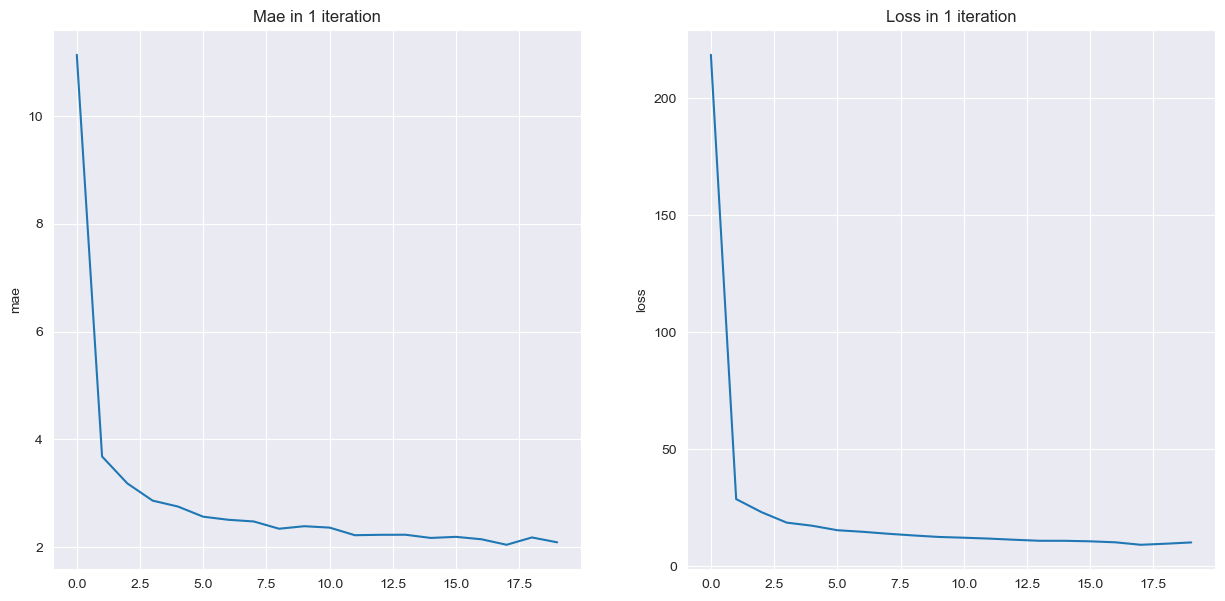

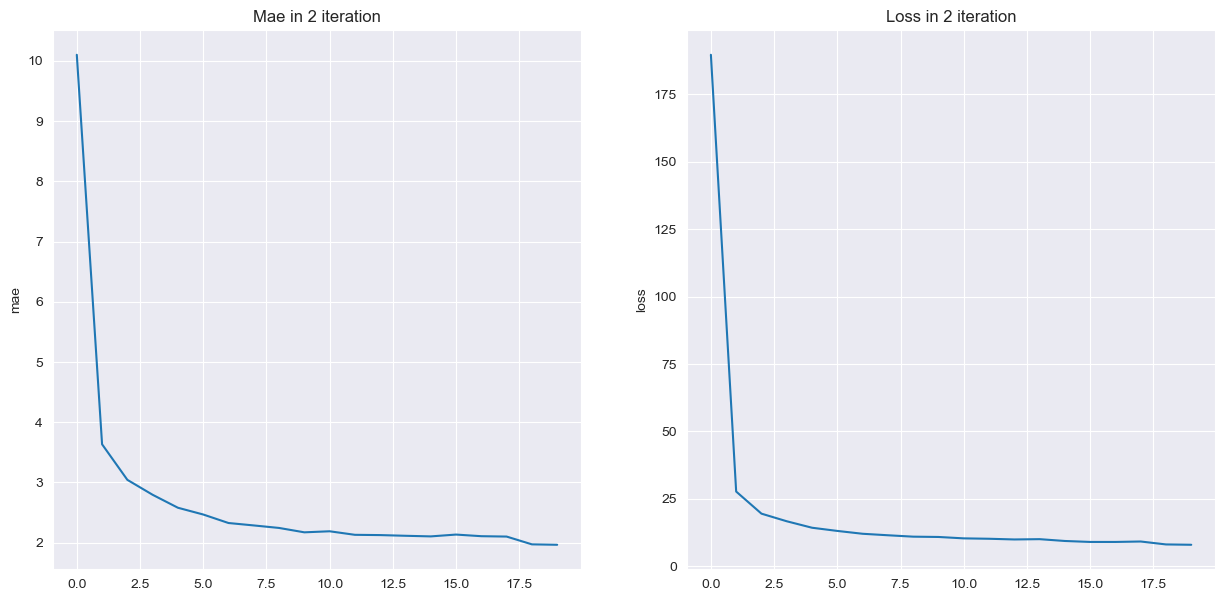

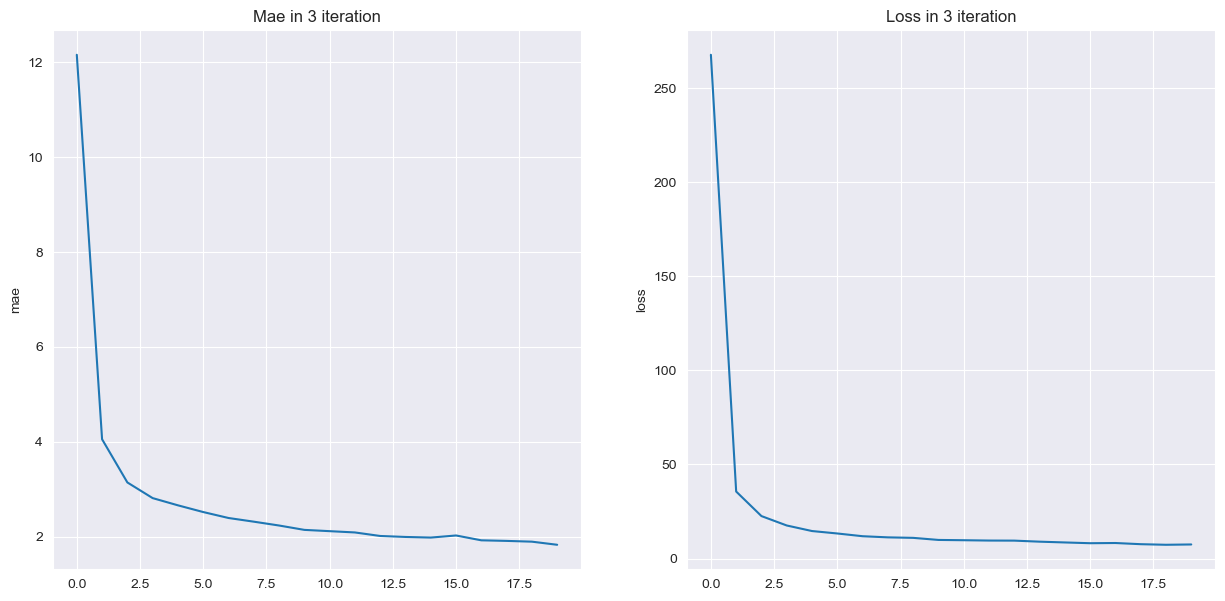

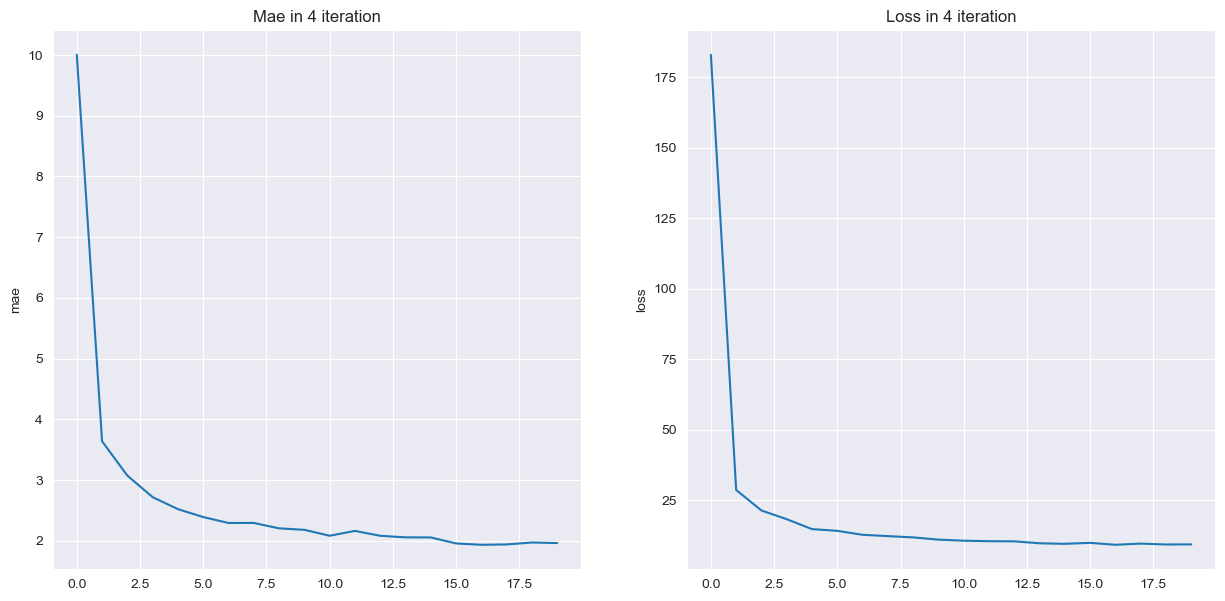

In [22]:
hand_cross_validation_model(num_epochs=20, batch_size=1)